# Reduccion de psk63 o no

In [1]:
import numpy as np
import pandas as pd

In [2]:
modes_df  = pd.read_csv('dataset_panoradio_hf_tags.csv')
signal_matrix = np.load('dataset_panoradio_hf.npy')

In [3]:
modes_df.drop(columns=['idx'], inplace=True)

In [36]:
modes = modes_df[' mode'].unique()

psk_modes = list(set(m for m in modes if 'psk' in m))

psk_mode_mask = modes_df[' mode'].isin(psk_modes)
psk_modes_df = modes_df[psk_mode_mask]
psk_signals = signal_matrix[psk_mode_mask]

In [5]:
is_psk63 = psk_modes_df[' mode'] == 'psk63'

In [6]:
ratio = is_psk63.sum() / np.size(is_psk63)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test_val, y_train, y_test_val = train_test_split(
    np.log(np.abs(np.fft.fft(psk_signals)) + 1e-127), is_psk63,
    random_state=42,
    test_size=0.4,
    stratify=is_psk63,
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val,
    random_state=42,
    test_size=0.5,
    stratify=y_test_val,
)

In [13]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    # --- TUS PARÁMETROS ORIGINALES ---
    n_estimators=2000,
    learning_rate=0.05,
    
    # Frenos de complejidad (INTACTOS)
    max_depth=4,
    min_child_weight=3,
    
    # Frenos de aleatoriedad (INTACTOS)
    subsample=0.7,
    colsample_bytree=0.3,
    
    # Regularización matemática (INTACTA)
    gamma=1,
    reg_alpha=5,
    reg_lambda=10,
    
    # --- ÚNICO CAMBIO NECESARIO ---
    objective='binary:logistic', # Obligatorio para clasificación de 2 clases
    # ------------------------------
    
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=50,

    # Relación entre cat A y cat B
    scale_pos_weight=ratio
)

In [14]:
xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=2,
)

[0]	validation_0-logloss:0.68837	validation_1-logloss:0.68847
[2]	validation_0-logloss:0.68342	validation_1-logloss:0.68438
[4]	validation_0-logloss:0.67865	validation_1-logloss:0.68057
[6]	validation_0-logloss:0.67462	validation_1-logloss:0.67743
[8]	validation_0-logloss:0.67039	validation_1-logloss:0.67403
[10]	validation_0-logloss:0.66696	validation_1-logloss:0.67109
[12]	validation_0-logloss:0.66295	validation_1-logloss:0.66803
[14]	validation_0-logloss:0.65922	validation_1-logloss:0.66497
[16]	validation_0-logloss:0.65576	validation_1-logloss:0.66215
[18]	validation_0-logloss:0.65167	validation_1-logloss:0.65857
[20]	validation_0-logloss:0.64729	validation_1-logloss:0.65470
[22]	validation_0-logloss:0.64301	validation_1-logloss:0.65117
[24]	validation_0-logloss:0.63893	validation_1-logloss:0.64767
[26]	validation_0-logloss:0.63633	validation_1-logloss:0.64551
[28]	validation_0-logloss:0.63264	validation_1-logloss:0.64197
[30]	validation_0-logloss:0.63011	validation_1-logloss:0.639

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.3
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, classes=None):

    y_pred = model.predict(X_test)

    # Generar la matriz de confusión
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    plt.figure(figsize=(8, 8))

    disp.plot(cmap=plt.cm.Blues, im_kw={'vmin': 0, 'vmax': 1})

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=90) # Rotar etiquetas eje X
    plt.yticks(rotation=0)  # Mantener etiquetas eje Y horizontales



<Figure size 800x800 with 0 Axes>

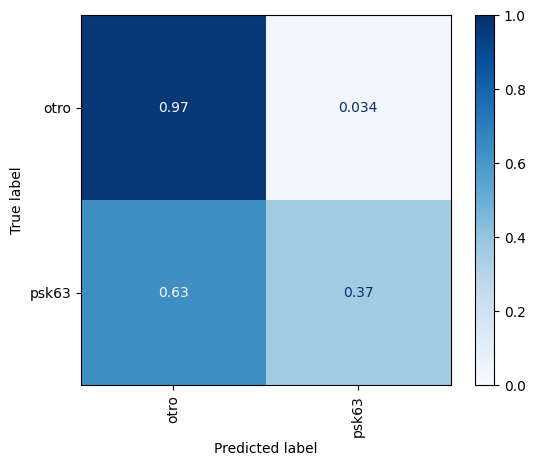

In [16]:
plot_confusion_matrix(xgb, X_test, y_test, classes=['otro', 'psk63'])

In [ ]:
mag = np.abs(signal_matrix)
mag

array([[1.2384175 , 1.22294789, 1.19319733, ..., 1.19755595, 1.11699368,
        1.16595333],
       [0.0113554 , 0.05515446, 0.03140162, ..., 0.02214553, 0.03891071,
        0.01276892],
       [0.04221782, 0.00759256, 0.02702299, ..., 0.02727017, 0.02476647,
        0.02577681],
       ...,
       [0.75786851, 1.67032638, 0.75394732, ..., 0.84403355, 0.67409987,
        0.99181359],
       [1.13419169, 1.67809316, 0.95357459, ..., 0.56355653, 0.59452071,
        0.59222097],
       [1.02820707, 0.37260608, 0.43766443, ..., 0.59853758, 0.61680814,
        1.0821294 ]], shape=(172800, 2048))

In [ ]:
db25 = psk_modes_df[' snr'] == 25


best_sigs = [
    psk_signals[db25 & (psk_modes_df[' mode'] == mode)][0, :]
    for mode in psk_modes
]
best_sigs



[array([ 0.38603863+1.08232089j,  0.53707617+1.08515575j,
         0.63127065+0.97147683j, ..., -1.0157834 -0.75383071j,
        -1.00248138-0.57529449j, -1.0761215 -0.46037958j], shape=(2048,)),
 array([ 0.88713708+0.56337425j,  0.88843226+0.71627925j,
         0.80991212+0.81865445j, ..., -0.4819058 -1.02296676j,
        -0.36222916-1.06449499j, -0.25618833-1.16618511j], shape=(2048,)),
 array([-0.39573251-1.0405572j , -0.38645297-1.14522926j,
        -0.38353078-1.06491519j, ...,  0.45371838-0.70477043j,
         0.42955772-0.74441675j,  0.42477048-0.69435453j], shape=(2048,))]

## Envelopes, autocorrelación

In [35]:
fs = 6000 # Hz

In [44]:
from matplotlib.ticker import EngFormatter

Text(0.5, 0, 'Time')

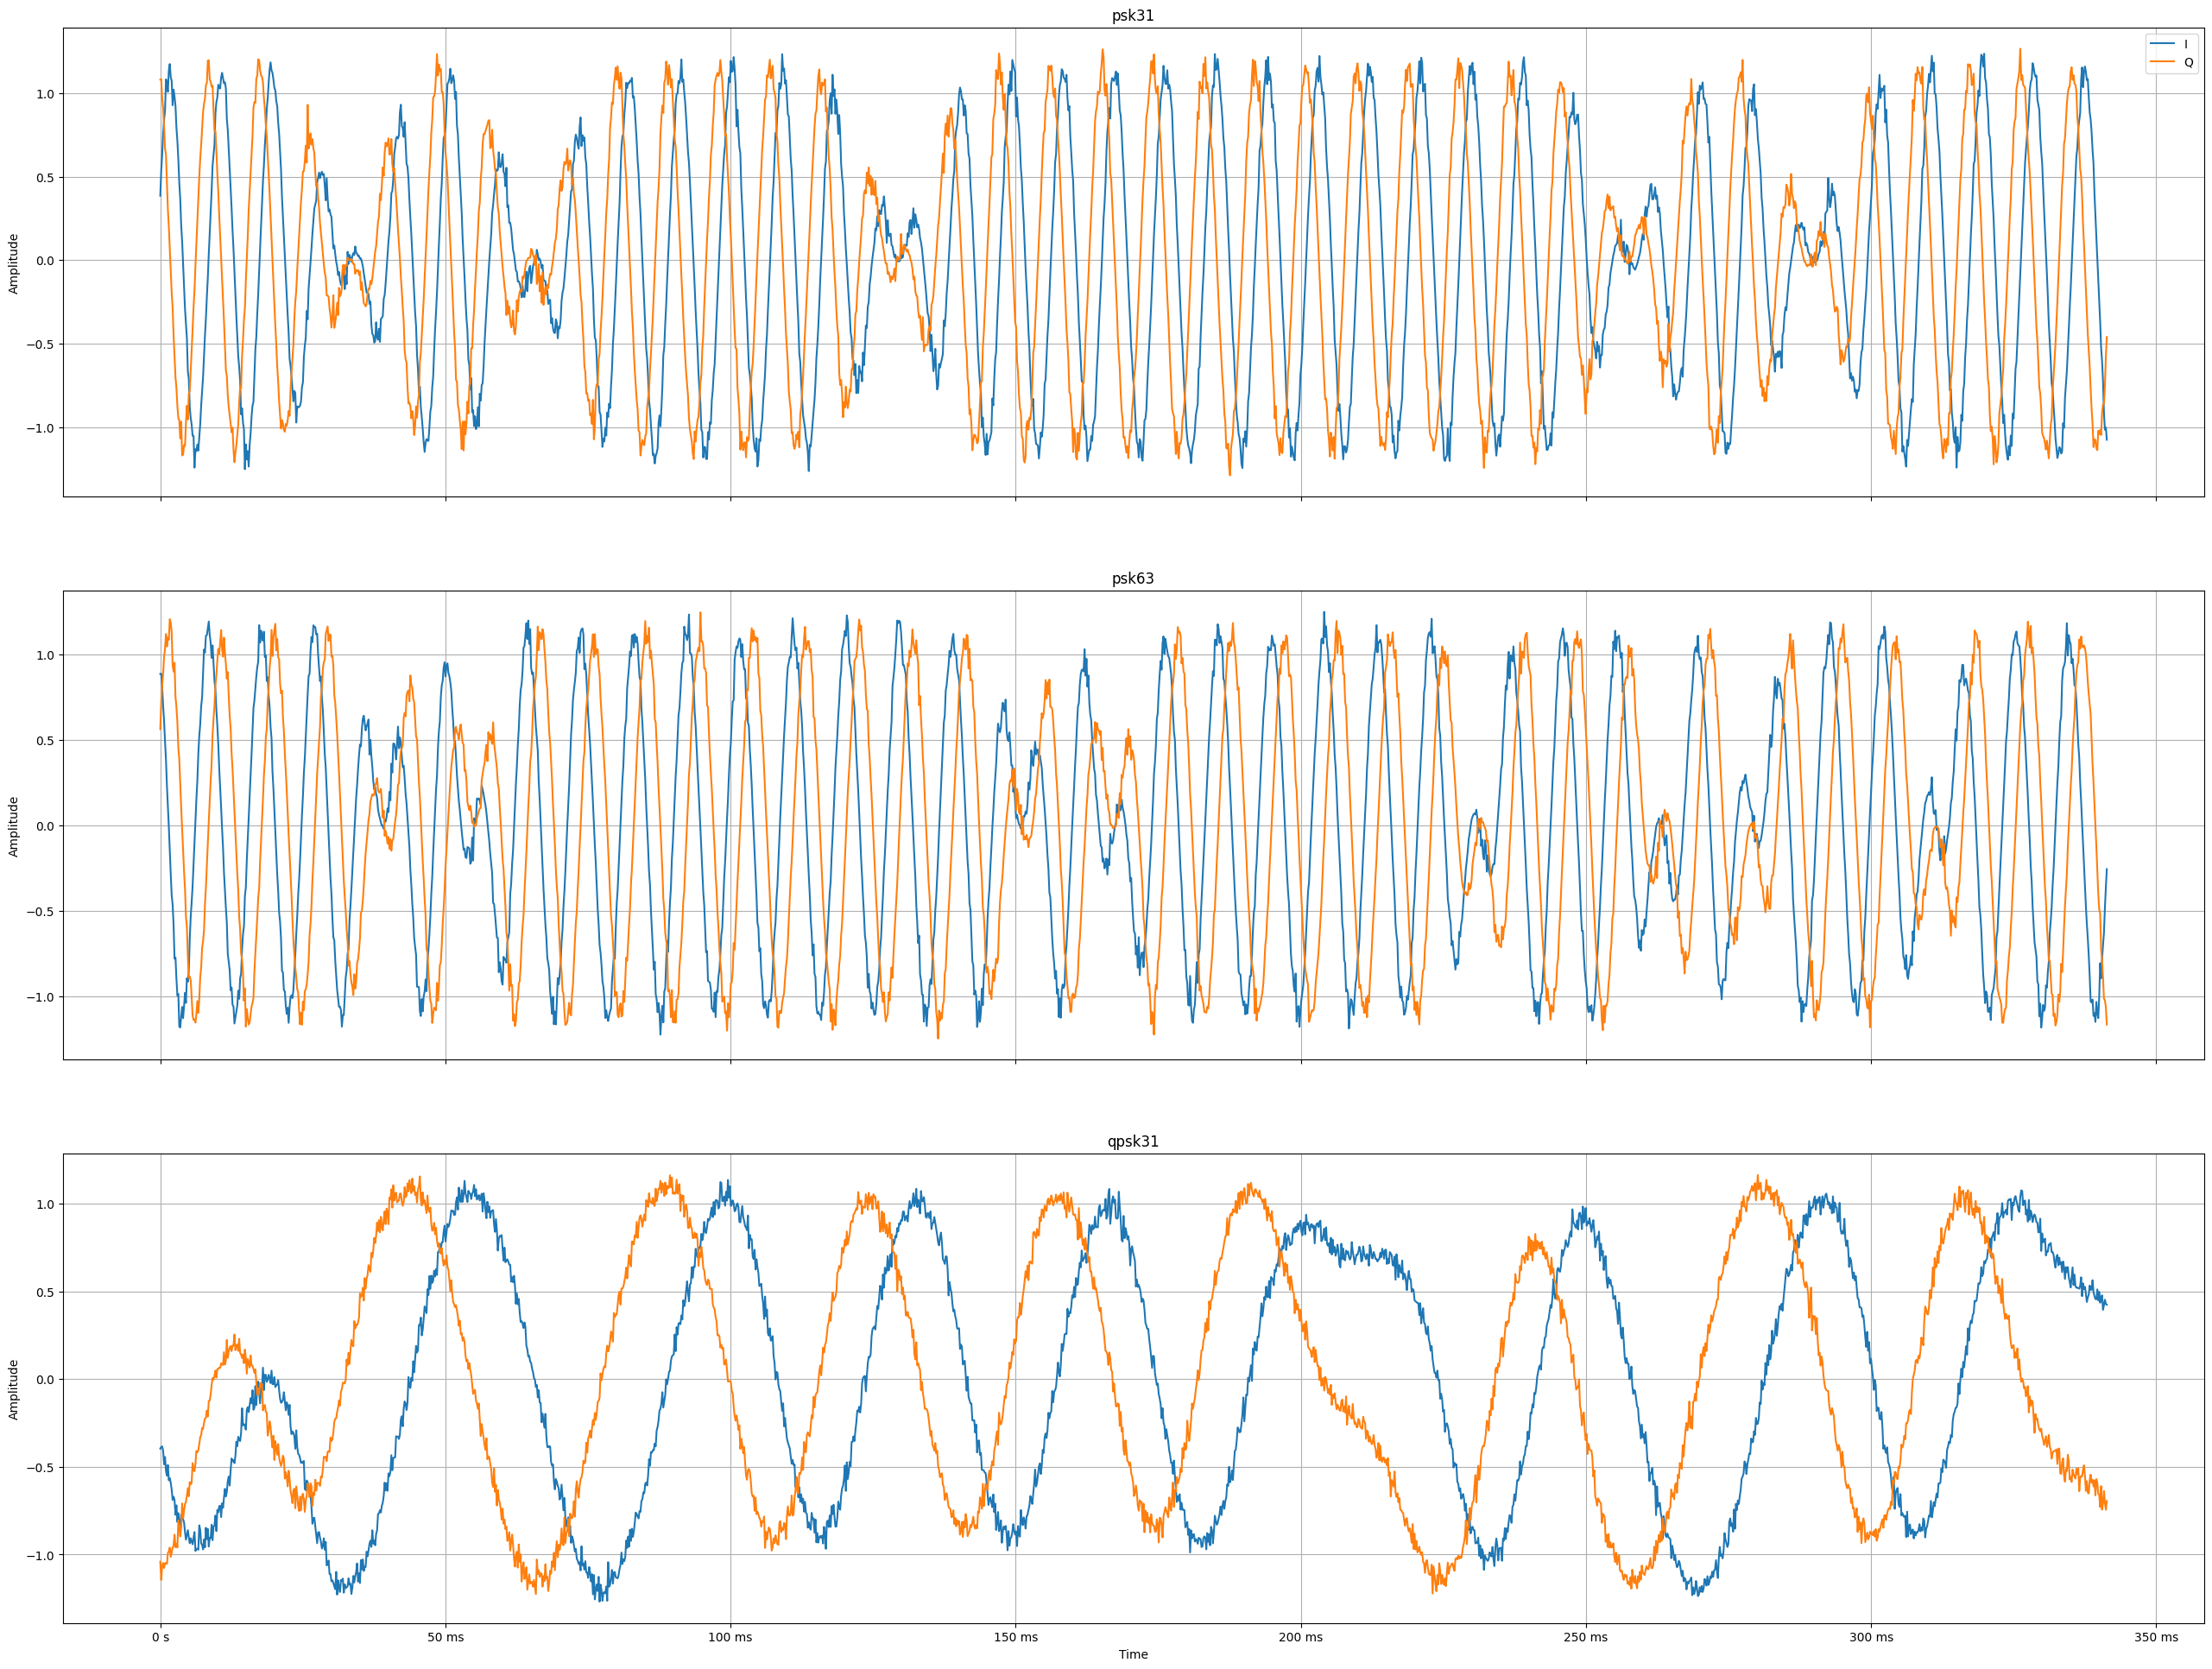

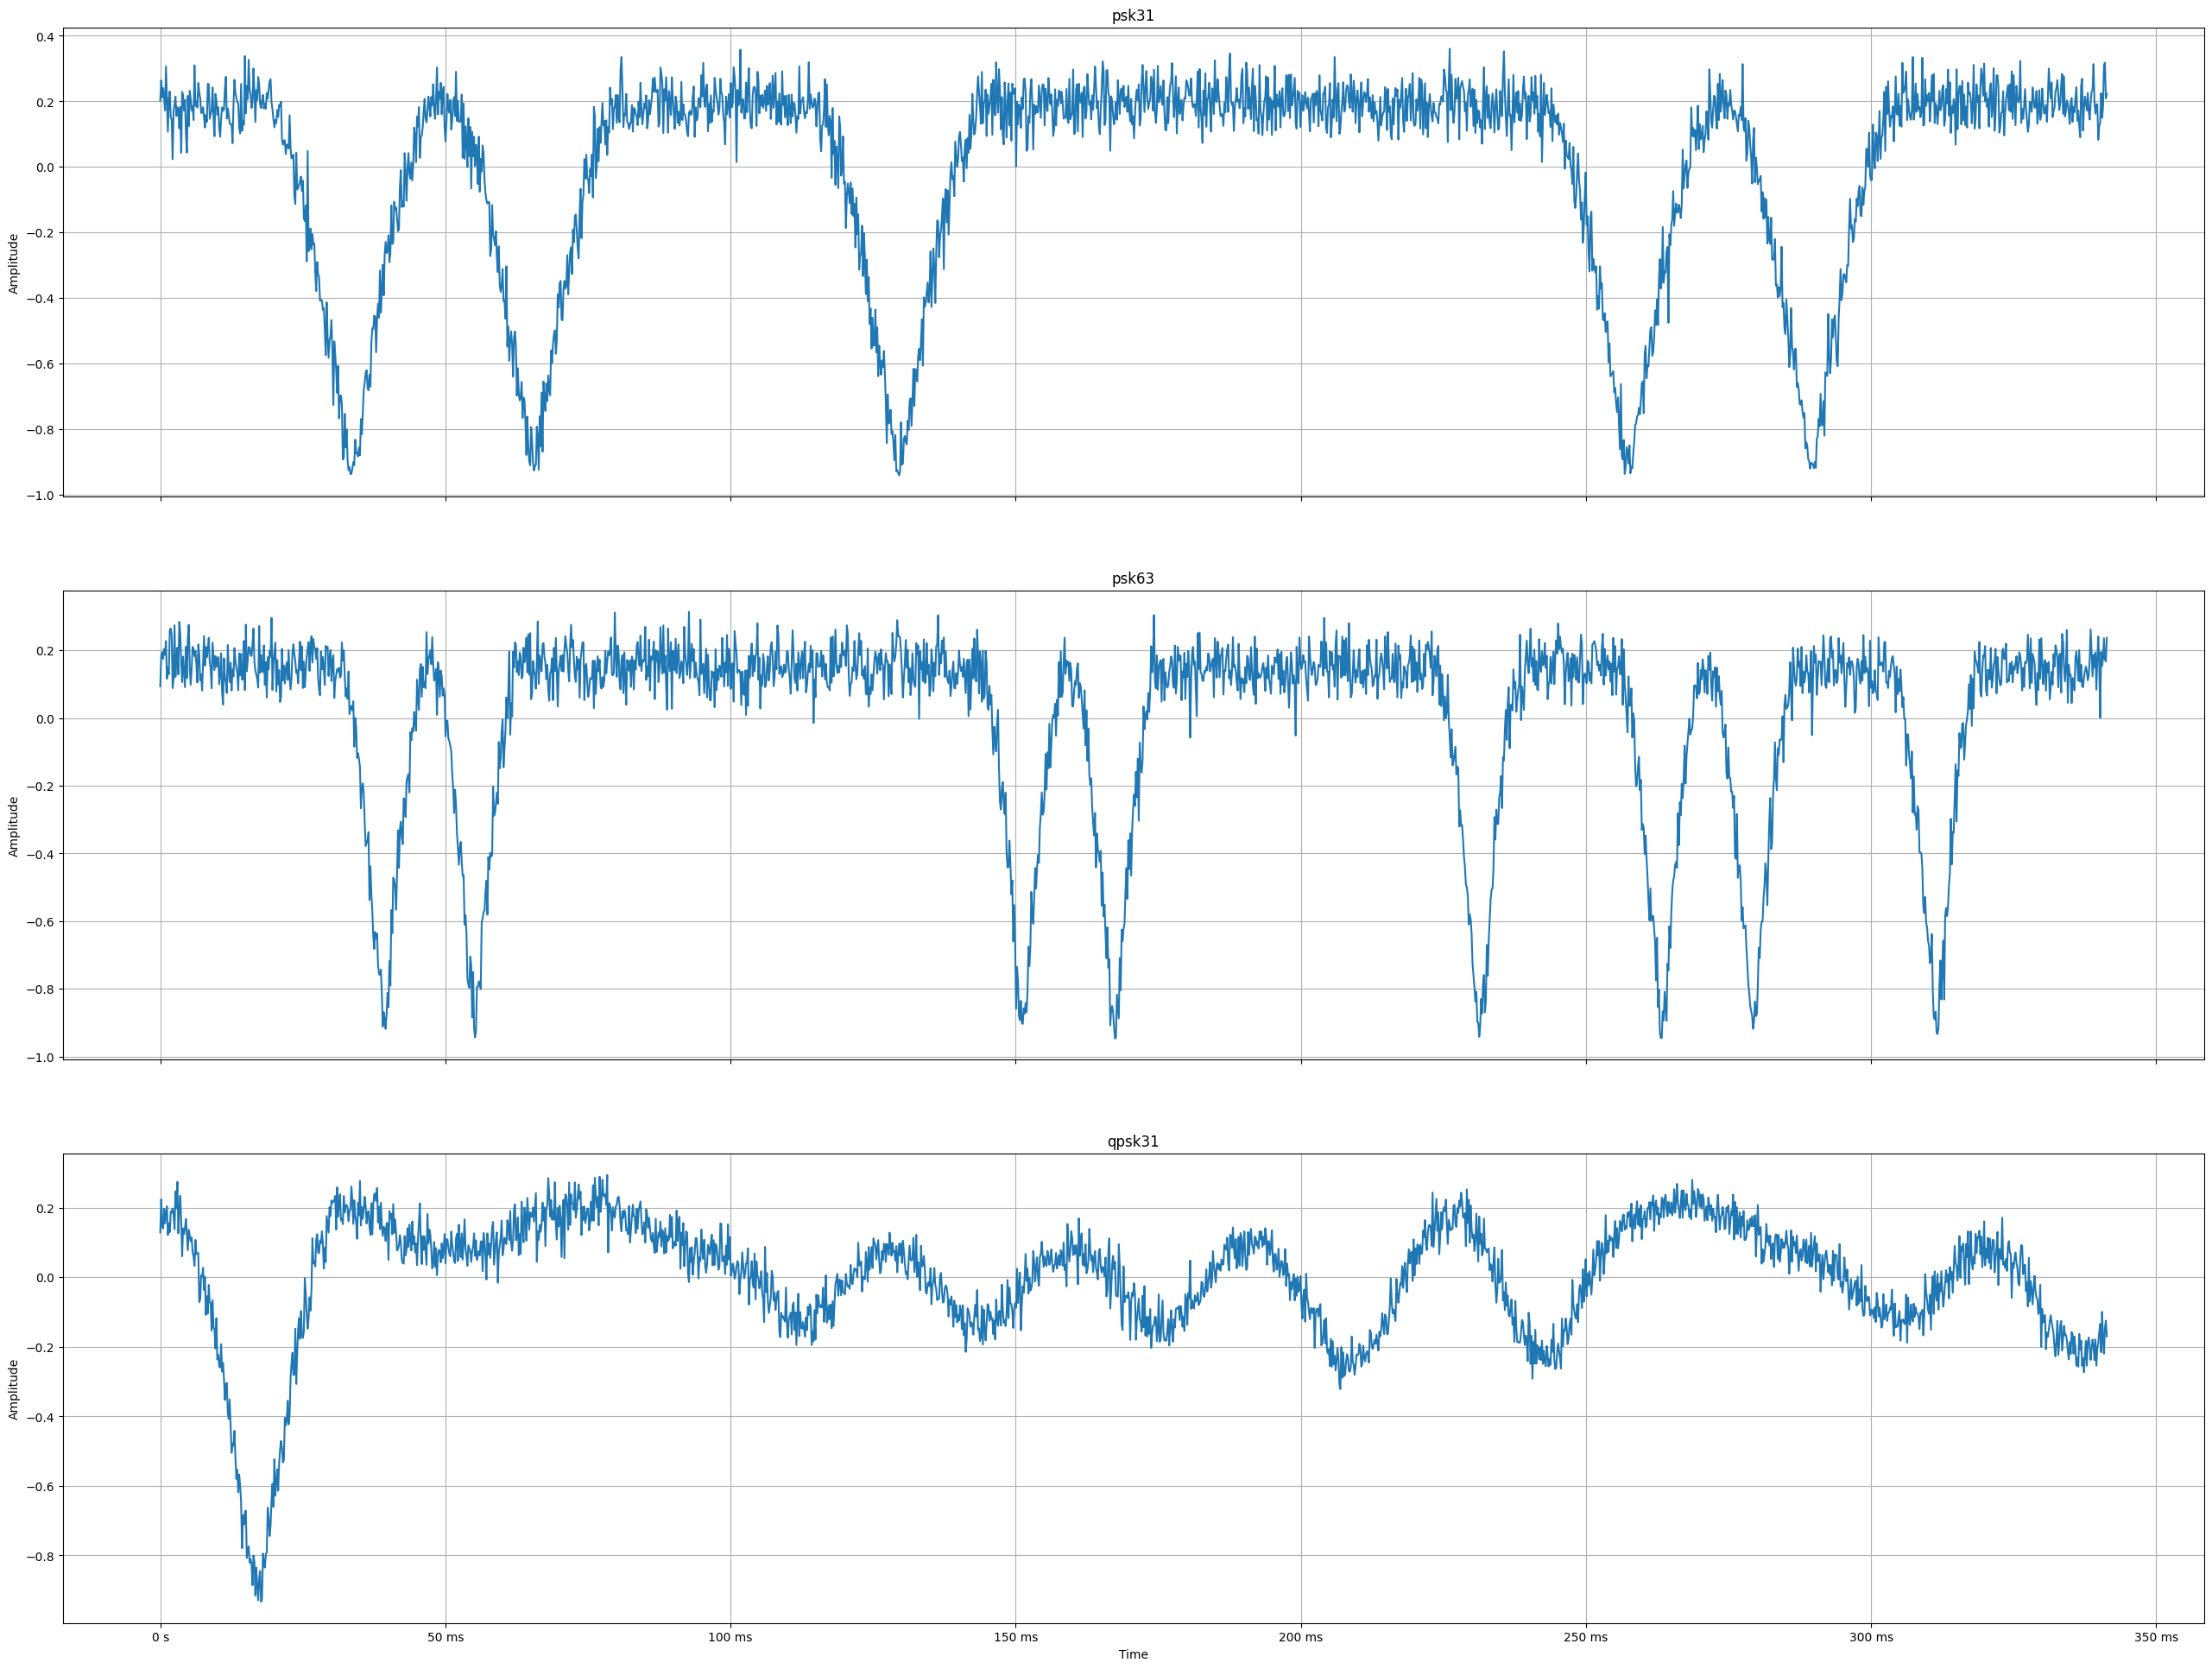

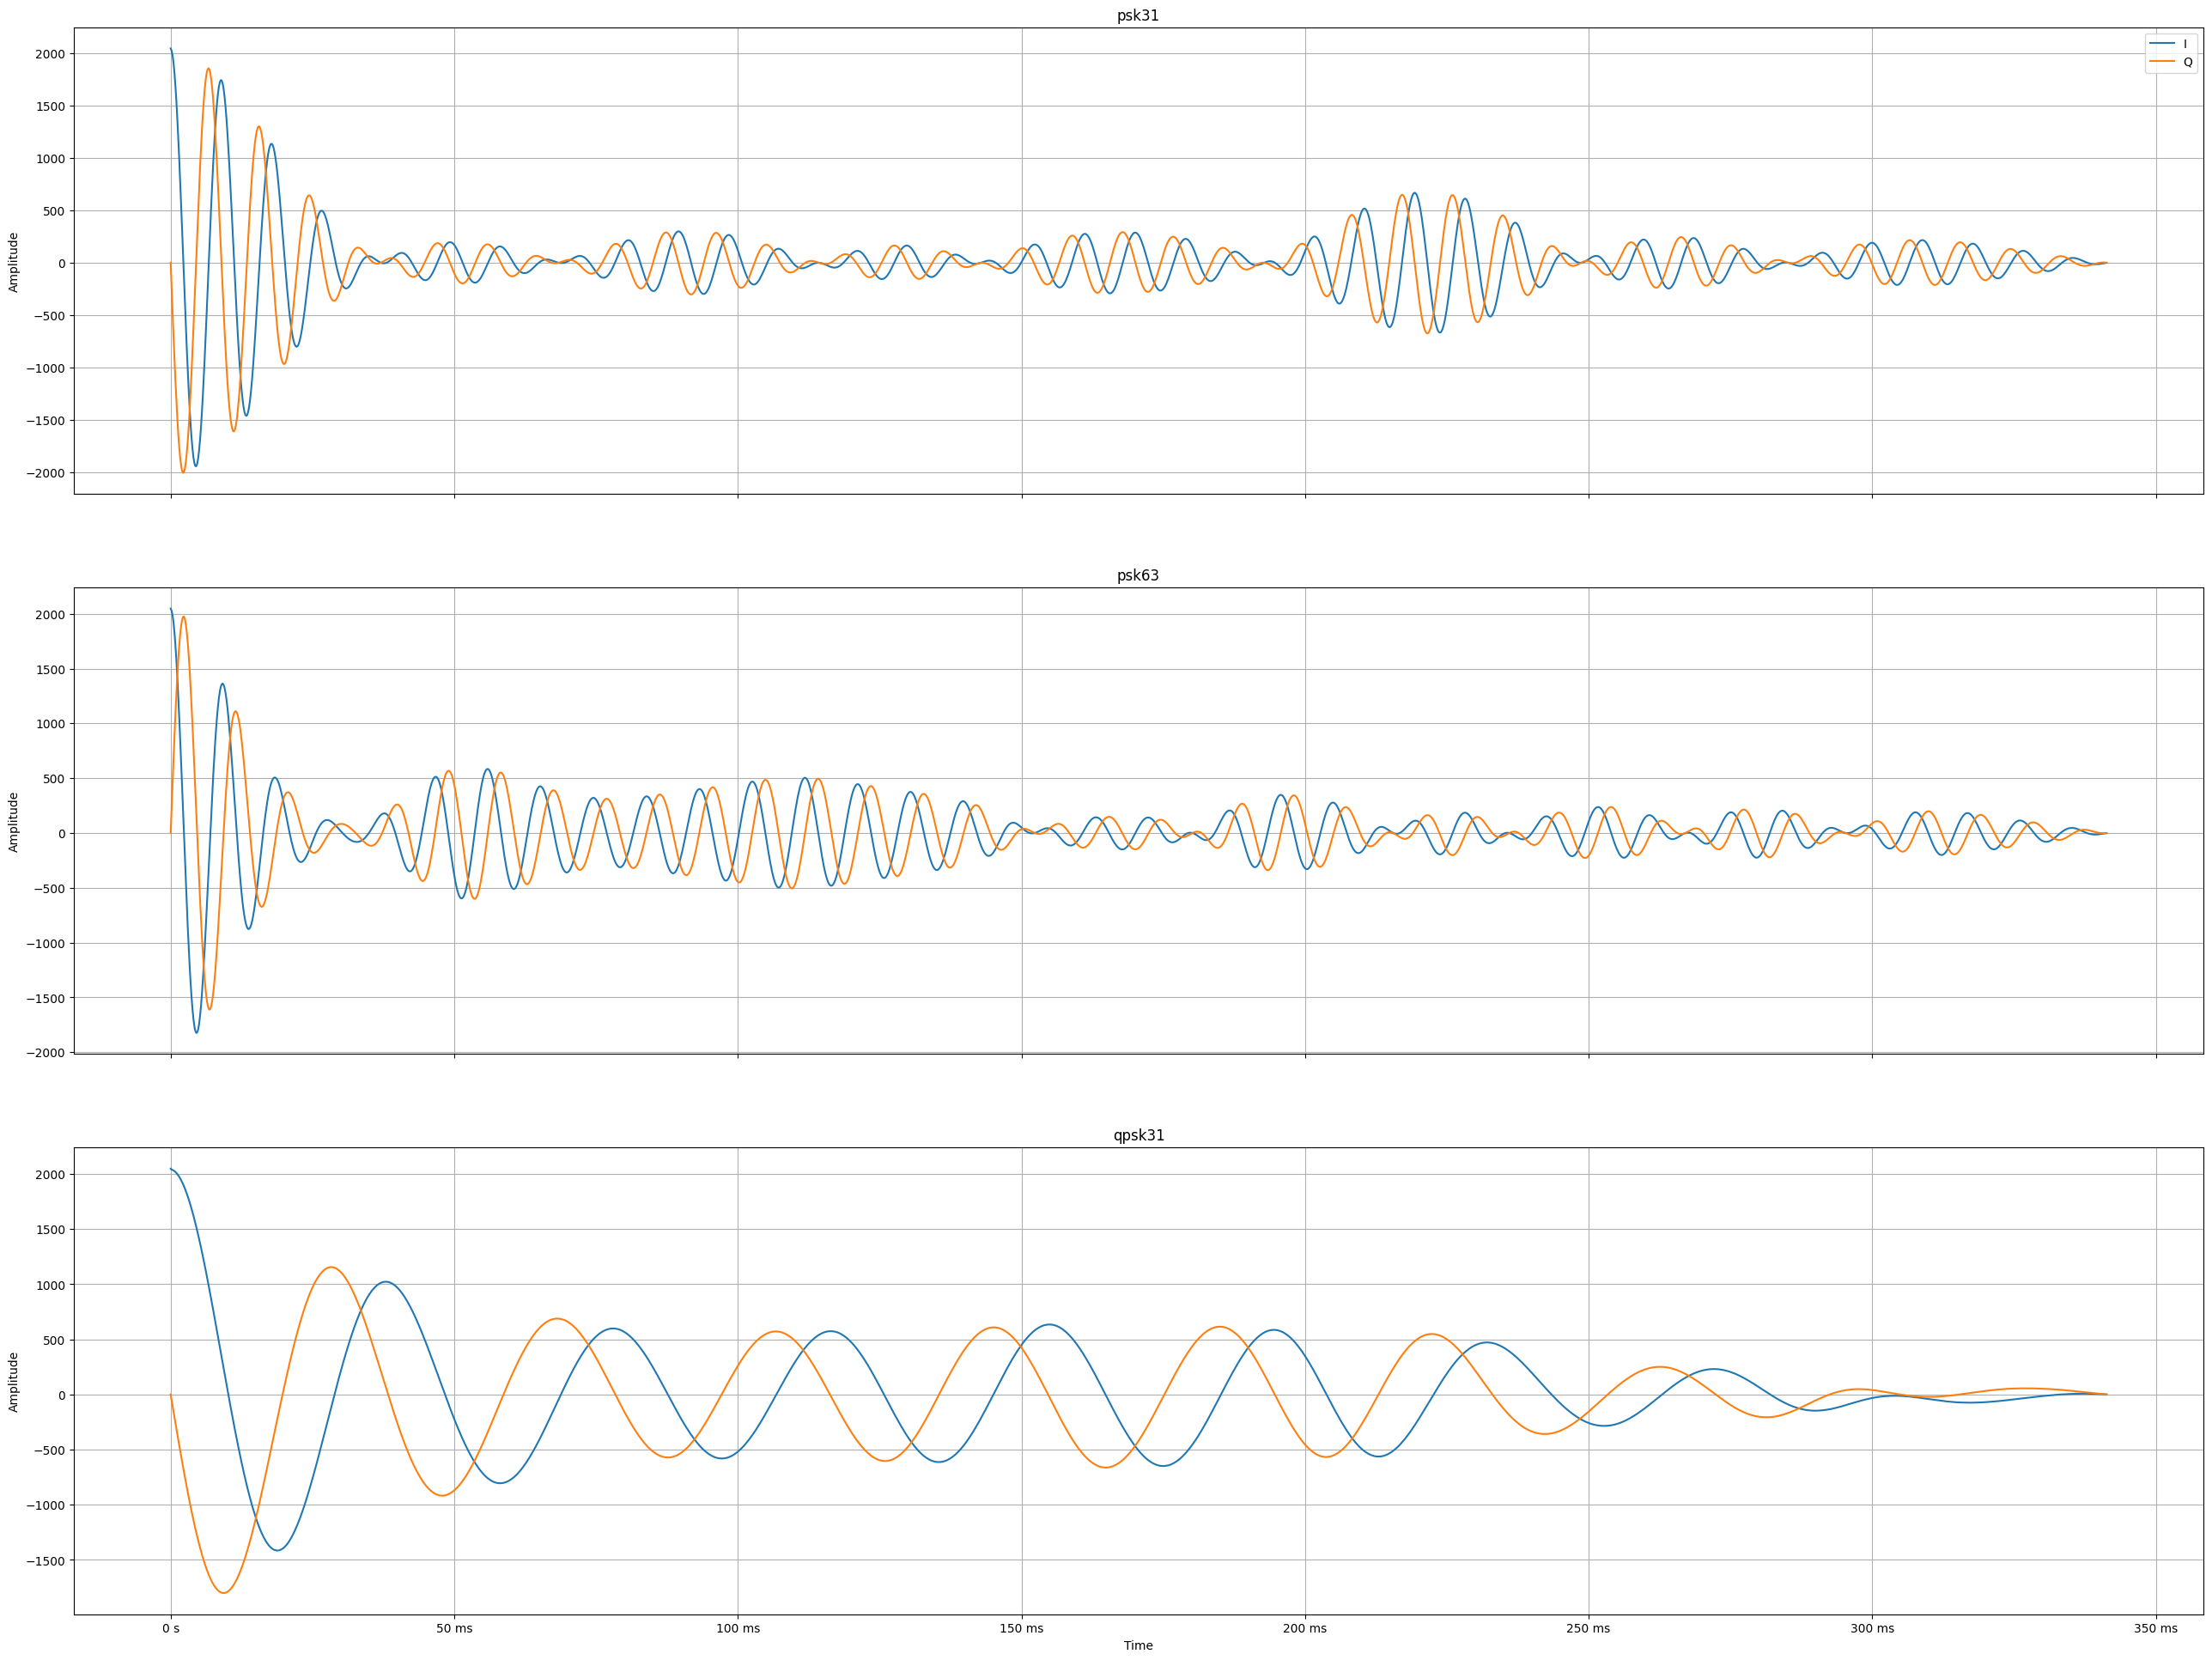

In [52]:
_, origs = plt.subplots(len(psk_modes), 1, figsize=(8*4, 8*len(psk_modes)), sharex=True)
_, envelopes = plt.subplots(len(psk_modes), 1, figsize=(8*4, 8*len(psk_modes)), sharex=True)
_, corr = plt.subplots(len(psk_modes), 1, figsize=(8*4, 8*len(psk_modes)), sharex=True)

time = np.linspace(0, np.size(best_sigs[0])/fs, np.size(best_sigs[0]))

for ax, mode, sig in zip(origs, psk_modes, best_sigs):
    ax.plot(time, np.real(sig), label='I')
    ax.plot(time, np.imag(sig), label='Q')
    ax.xaxis.set_major_formatter(EngFormatter(unit='s'))
    ax.grid()
    ax.set_ylabel('Amplitude')
    ax.set_title(mode)

for ax, mode, sig in zip(envelopes, psk_modes, best_sigs):
    mag = np.abs(sig)
    # remove zero frequency (DC)
    mag -= np.mean(mag)

    ax.plot(time, mag)
    ax.xaxis.set_major_formatter(EngFormatter(unit='s'))
    ax.set_ylabel('Amplitude')
    ax.grid()
    ax.set_title(mode)

for ax, mode, sig in zip(corr, psk_modes, best_sigs):
    corr_sig = np.correlate(sig, sig, mode='full')
    corr_sig = corr_sig[np.size(corr_sig)//2:]

    ax.plot(time, np.real(corr_sig), label='I')
    ax.plot(time, np.imag(corr_sig), label='Q')

    ax.xaxis.set_major_formatter(EngFormatter(unit='s'))
    ax.grid()
    ax.set_ylabel('Amplitude')
    ax.set_title(mode)


origs[0].legend()
origs[-1].set_xlabel('Time')
envelopes[-1].set_xlabel('Time')
corr[0].legend()
corr[-1].set_xlabel('Time')

## Modelo con envelopes

In [62]:
mod = np.abs(psk_signals)
mod -= np.tile(np.mean(mod, axis=1)[:, np.newaxis], (1, mod.shape[1]))
mod

array([[ 0.20221901,  0.2639037 ,  0.21167683, ...,  0.31805449,
         0.20893866,  0.2235775 ],
       [-0.13263811, -0.17483559, -0.20543984, ...,  0.18628242,
         0.18154532,  0.111482  ],
       [-0.6794879 , -0.65714344, -0.65422737, ...,  0.30798963,
         0.31499817,  0.17932412],
       ...,
       [ 0.46519839,  0.30680887,  0.00757855, ..., -0.03679835,
         0.41676448,  0.20068523],
       [-0.57608126, -0.34411456,  0.76775219, ...,  0.14013474,
        -0.55917388,  0.15604168],
       [ 0.07923562, -0.38313768, -0.18739137, ..., -0.00664079,
        -0.07821601,  0.45496675]], shape=(28800, 2048))

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(psk_modes_df[' mode'])

X_train, X_test_val, y_train, y_test_val = train_test_split(
    mod, y,
    random_state=42,
    test_size=0.4,
    stratify=is_psk63,
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val,
    random_state=42,
    test_size=0.5,
    stratify=y_test_val,
)

In [65]:

from xgboost import XGBClassifier

xgb = XGBClassifier(
    # --- TUS PARÁMETROS ORIGINALES ---
    n_estimators=2000,
    learning_rate=0.05,
    
    # Frenos de complejidad (INTACTOS)
    max_depth=4,
    min_child_weight=3,
    
    # Frenos de aleatoriedad (INTACTOS)
    subsample=0.7,
    colsample_bytree=0.3,
    
    # Regularización matemática (INTACTA)
    gamma=1,
    reg_alpha=5,
    reg_lambda=10,
    
    # --- ÚNICO CAMBIO NECESARIO ---
    objective='binary:logistic', # Obligatorio para clasificación de 2 clases
    # ------------------------------
    
    n_jobs=-1,
    random_state=42,
    tree_method='hist',
    early_stopping_rounds=50,

    # Relación entre cat A y cat B
    # scale_pos_weight=ratio
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=2,
)

c:\Users\gsus\Documents\uni\inteligencia en red\trabajo final\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [14:21:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.09582	validation_1-mlogloss:1.09692
[2]	validation_0-mlogloss:1.09042	validation_1-mlogloss:1.09343
[4]	validation_0-mlogloss:1.08522	validation_1-mlogloss:1.09008
[6]	validation_0-mlogloss:1.07980	validation_1-mlogloss:1.08666
[8]	validation_0-mlogloss:1.07469	validation_1-mlogloss:1.08352
[10]	validation_0-mlogloss:1.06951	validation_1-mlogloss:1.08042
[12]	validation_0-mlogloss:1.06445	validation_1-mlogloss:1.07705
[14]	validation_0-mlogloss:1.05963	validation_1-mlogloss:1.07398
[16]	validation_0-mlogloss:1.05477	validation_1-mlogloss:1.07096
[18]	validation_0-mlogloss:1.05009	validation_1-mlogloss:1.06785
[20]	validation_0-mlogloss:1.04518	validation_1-mlogloss:1.06457
[22]	validation_0-mlogloss:1.04047	validation_1-mlogloss:1.06142
[24]	validation_0-mlogloss:1.03571	validation_1-mlogloss:1.05861
[26]	validation_0-mlogloss:1.03120	validation_1-mlogloss:1.05571
[28]	validation_0-mlogloss:1.02667	validation_1-mlogloss:1.05263
[30]	validation_0-mlogloss:1.0

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.3
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


<Figure size 800x800 with 0 Axes>

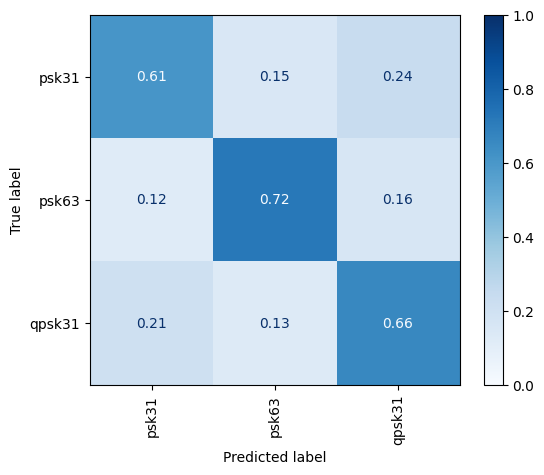

In [67]:
plot_confusion_matrix(xgb, X_test, y_test, classes=le.classes_)

In [70]:
from pathlib import Path
import joblib

PATH = Path(r'C:\Users\gsus\Documents\uni\inteligencia en red\trabajo final')
MODEL_PATH = PATH / 'modelos'

joblib.dump(le, MODEL_PATH / 'entre_psk_encoder.joblib')
joblib.dump(xgb, MODEL_PATH / 'entre_psk_modelo.joblib')

['C:\\Users\\gsus\\Documents\\uni\\inteligencia en red\\trabajo final\\modelos\\entre_psk_modelo.joblib']